# E4 네이버 영화리뷰 감성분석 도전하기
일시: 2020년 1월 14일 목요일

# Step 1. 데이터 준비와 확인

**1. 네이버 영화의 댓글을 모아 구성된 [Naver sentiment movie corpus](https://github.com/e9t/nsmc)를 다운받아줍니다.**

```
$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
$ mv ratings_*.txt ~/aiffel/sentiment_classification
```

In [2]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# Step 2. 데이터로더 구성

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [3]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# Step 3. 모델구성을 위한 데이터 분석 및 가공

In [6]:
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


**데이터셋 내 문장 길이 분포를 파악합니다.** 

In [7]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [8]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


**적절한 최대 문장 길이를 지정합니다.**

In [9]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


**```keras.preprocessing.sequence.pad_sequences```을 활용한 패딩 추가합니다.**

In [10]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


# Step 4. 모델 구성 및 validation set 구성

## (1) RNN

**모델을 구성합니다.**

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# RNN model 설계 
model_rnn = keras.Sequential()
model_rnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model_rnn.add(keras.layers.Dense(8, activation='relu'))
model_rnn.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


## (2) 1-D Convolution Neural Network(1-D CNN)

In [12]:
# 1-D Convolution Neural Network(1-D CNN)
import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = 10000 # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16 # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model_oned = keras.Sequential()
model_oned.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_oned.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_oned.add(keras.layers.MaxPooling1D(5))
model_oned.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_oned.add(keras.layers.GlobalMaxPooling1D())
model_oned.add(keras.layers.Dense(8, activation='relu'))
model_oned.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_oned.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

## (3) GlobalMaxPooling1D() 레이어 하나만 사용하는 방법

In [13]:
# GlobalMaxPooling1D() 레이어 하나만 사용하는 방법
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model_max = keras.Sequential()
model_max.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_max.add(keras.layers.GlobalMaxPooling1D())
model_max.add(keras.layers.Dense(8, activation='relu'))
model_max.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_max.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


**validation set을 구성합니다**

In [14]:
# validation set 20000건 분리
X_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 30000건
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 41)
(96182,)


# Step 5. 모델 훈련 개시 

In [21]:
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 12

history_rnn = model_rnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/12
188/188 [==============================] - 2s 8ms/step - loss: 0.1240 - accuracy: 0.9584 - val_loss: 0.6310 - val_accuracy: 0.8275
Epoch 2/12
188/188 [==============================] - 1s 6ms/step - loss: 0.1195 - accuracy: 0.9601 - val_loss: 0.6658 - val_accuracy: 0.8267
Epoch 3/12
188/188 [==============================] - 1s 6ms/step - loss: 0.1138 - accuracy: 0.9619 - val_loss: 0.6651 - val_accuracy: 0.8250
Epoch 4/12
188/188 [==============================] - 1s 6ms/step - loss: 0.1102 - accuracy: 0.9633 - val_loss: 0.6737 - val_accuracy: 0.8226
Epoch 5/12
188/188 [==============================] - 1s 6ms/step - loss: 0.1110 - accuracy: 0.9630 - val_loss: 0.6910 - val_accuracy: 0.8237
Epoch 6/12
188/188 [==============================] - 1s 6ms/step - loss: 0.1046 - accuracy: 0.9653 - val_loss: 0.7192 - val_accuracy: 0.8231
Epoch 7/12
188/188 [==============================] - 1s 6ms/step - loss: 0.1021 - accuracy: 0.9661 - val_loss: 0.7190 - val_accuracy: 0.8229
Epoch 

In [22]:
model_oned.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 12

history_oned = model_oned.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/12
188/188 [==============================] - 1s 5ms/step - loss: 0.0356 - accuracy: 0.9892 - val_loss: 0.9217 - val_accuracy: 0.8153
Epoch 2/12
188/188 [==============================] - 1s 5ms/step - loss: 0.0301 - accuracy: 0.9913 - val_loss: 0.9573 - val_accuracy: 0.8161
Epoch 3/12
188/188 [==============================] - 1s 5ms/step - loss: 0.0269 - accuracy: 0.9922 - val_loss: 0.9693 - val_accuracy: 0.8114
Epoch 4/12
188/188 [==============================] - 1s 5ms/step - loss: 0.0248 - accuracy: 0.9926 - val_loss: 1.0271 - val_accuracy: 0.8113
Epoch 5/12
188/188 [==============================] - 1s 5ms/step - loss: 0.0236 - accuracy: 0.9928 - val_loss: 1.0540 - val_accuracy: 0.8082
Epoch 6/12
188/188 [==============================] - 1s 5ms/step - loss: 0.0219 - accuracy: 0.9933 - val_loss: 1.1144 - val_accuracy: 0.8108
Epoch 7/12
188/188 [==============================] - 1s 5ms/step - loss: 0.0215 - accuracy: 0.9931 - val_loss: 1.1271 - val_accuracy: 0.8107
Epoch 

In [23]:
model_max.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 12   

history_max = model_max.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/12
188/188 [==============================] - 1s 4ms/step - loss: 0.6210 - accuracy: 0.6946 - val_loss: 0.5006 - val_accuracy: 0.8101
Epoch 2/12
188/188 [==============================] - 1s 4ms/step - loss: 0.4169 - accuracy: 0.8325 - val_loss: 0.3762 - val_accuracy: 0.8373
Epoch 3/12
188/188 [==============================] - 1s 4ms/step - loss: 0.3368 - accuracy: 0.8594 - val_loss: 0.3556 - val_accuracy: 0.8441
Epoch 4/12
188/188 [==============================] - 1s 4ms/step - loss: 0.3018 - accuracy: 0.8759 - val_loss: 0.3538 - val_accuracy: 0.8456
Epoch 5/12
188/188 [==============================] - 1s 4ms/step - loss: 0.2775 - accuracy: 0.8876 - val_loss: 0.3578 - val_accuracy: 0.8460
Epoch 6/12
188/188 [==============================] - 1s 4ms/step - loss: 0.2580 - accuracy: 0.8968 - val_loss: 0.3659 - val_accuracy: 0.8447
Epoch 7/12
188/188 [==============================] - 1s 4ms/step - loss: 0.2414 - accuracy: 0.9042 - val_loss: 0.3758 - val_accuracy: 0.8440
Epoch 

# Step 6. Loss, Accuracy 그래프 시각화

**각 모델의 성능평가를 하고, 각 결과에 대한 히스토리를 참고하여, Traing과 validation에 대한 Loss와 Accuracy에 대한 그래프를 그립니다.** 

Training and validation loss를 그려 보면, 몇 epoch까지의 트레이닝이 적절한지 최적점을 추정해 볼 수 있습니다.     
validation loss의 그래프가 train loss와의 이격이 발생하게 되면 더이상의 트레이닝은 무의미해지게 마련입니다.

## (1) RNN

In [106]:
results_rnn = model_rnn.evaluate(X_test,  y_test, verbose=2)

print(results_rnn)

1537/1537 - 3s - loss: 0.7911 - accuracy: 0.8159
[0.7910993695259094, 0.8158960342407227]


In [107]:
history_dict_rnn = history_rnn.history
print(history_dict_rnn.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### Training과 validation의 Loss

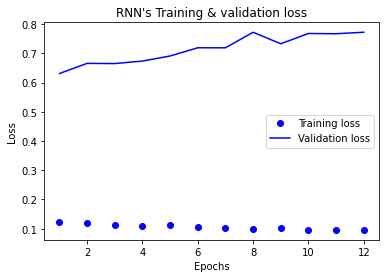

In [108]:
import matplotlib.pyplot as plt

acc_rnn = history_dict_rnn['accuracy']
val_acc_rnn = history_dict_rnn['val_accuracy']
loss_rnn = history_dict_rnn['loss']
val_loss_rnn = history_dict_rnn['val_loss']

epochs_rnn = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs_rnn, loss_rnn, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs_rnn, val_loss_rnn, 'b', label='Validation loss')
plt.title('RNN\'s Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Training과 validation의 Accuracy

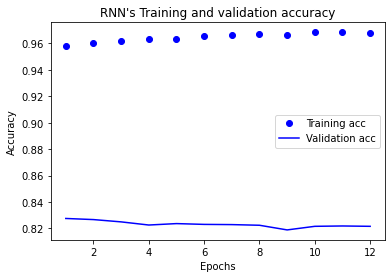

In [109]:
plt.clf()  

plt.plot(epochs_rnn, acc_rnn, 'bo', label='Training acc')
plt.plot(epochs_rnn, val_acc_rnn, 'b', label='Validation acc')
plt.title('RNN\'s Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## (2) 1-D Convolution Neural Network(1-D CNN)

In [110]:
results_oned = model_oned.evaluate(X_test,  y_test, verbose=2)

print(results_oned)

1537/1537 - 2s - loss: 1.2715 - accuracy: 0.8003
[1.2715052366256714, 0.8002725839614868]


In [111]:
history_dict_oned = history_oned.history
print(history_dict_oned.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### Training과 validation의 Loss

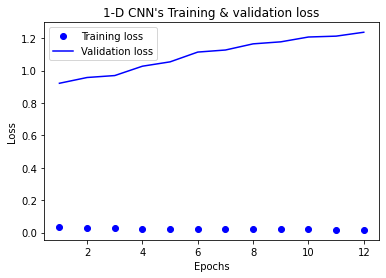

In [112]:
import matplotlib.pyplot as plt

acc_oned = history_dict_oned['accuracy']
val_acc_oned = history_dict_oned['val_accuracy']
loss_oned = history_dict_oned['loss']
val_loss_oned = history_dict_oned['val_loss']

epochs_oned = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs_oned, loss_oned, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs_oned, val_loss_oned, 'b', label='Validation loss')
plt.title('1-D CNN\'s Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Training과 validation의 Accuracy

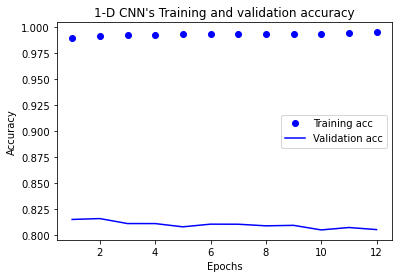

In [113]:
plt.clf()   # 그림을 초기화

plt.plot(epochs_oned, acc_oned, 'bo', label='Training acc')
plt.plot(epochs_oned, val_acc_oned, 'b', label='Validation acc')
plt.title('1-D CNN\'s Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## (3) GlobalMaxPooling1D() 레이어 하나만 사용하는 방법

In [114]:
results_max = model_max.evaluate(X_test,  y_test, verbose=2)

print(results_max)

1537/1537 - 2s - loss: 0.4548 - accuracy: 0.8295
[0.4547699987888336, 0.8294851183891296]


In [115]:
history_dict_max = history_max.history
print(history_dict_max.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### Training과 validation의 Loss

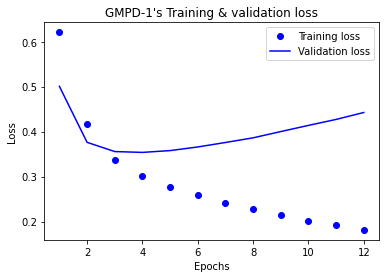

In [116]:
import matplotlib.pyplot as plt

acc_max= history_dict_max['accuracy']
val_acc_max = history_dict_max['val_accuracy']
loss_max = history_dict_max['loss']
val_loss_max = history_dict_max['val_loss']

epochs_max = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs_max, loss_max, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs_max, val_loss_max, 'b', label='Validation loss')
plt.title('GMPD-1\'s Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Training과 validation의 Accuracy

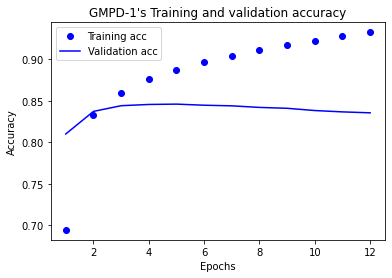

In [117]:
plt.clf()  

plt.plot(epochs_max, acc_max, 'bo', label='Training acc')
plt.plot(epochs_max, val_acc_max, 'b', label='Validation acc')
plt.title('GMPD-1\'s Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Step 7. 학습된 임베딩 레이어 분석

**모델에 사용한 임베딩레이어에 학습된 워드 벡터들이 의미 공간상에 유의미한 형태로 학습되었는지 각 모델별로 확인해봅니다.**

**워드 벡터 파일을 저장할 디렉토리를 먼저 설치하고, 워드 벡터를 다루는데 유용한 ```gensim```패키지를 설치합니다.**

```
$ mkdir -p ~/aiffel/sentiment_classification 
$ pip install gensim
```

## (1) RNN

In [73]:
embedding_layer_rnn = model_rnn.layers[0]
weights_rnn = embedding_layer_rnn.get_weights()[0]
print(weights_rnn.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [78]:
import os

# 학습한 Embedding 파라미터를 새로운 파일에 써서 저장
word2vec_rnn_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_rnn.txt'
f_rnn = open(word2vec_rnn_file_path, 'w')
f_rnn.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇 개의 벡터를 얼마 사이즈로 기재할지 타이틀을 작성

# 단어 개수에서 특수문자 4개는 제외하고, 그 만큼 워드 벡터를 파일에 기록 
vectors_rnn = model_rnn.get_weights()[0]
for i in range(4,vocab_size):
    f_rnn.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors_rnn[i, :])))))
f_rnn.close()

**```gensim```패키지를 이용해 위에 저장해둔 임베딩 파라미터를 읽어서 word vector로 활용합니다.**

In [80]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors_rnn = Word2VecKeyedVectors.load_word2vec_format(word2vec_rnn_file_path, binary=False)
vector_rnn = word_vectors_rnn['연기']
vector_rnn

array([ 0.13870445, -0.1409035 ,  0.00274901, -0.20433758, -0.01544106,
        0.17637348,  0.1082819 , -0.02633857,  0.05148479, -0.06924178,
       -0.02395523,  0.0293787 , -0.07658944,  0.06172883,  0.00542384,
       -0.12710173], dtype=float32)

**학습된 워드 벡터들이 의미 공간 상에 유의미하게 학습되었는지 보기 위해 단어를 하나 주고, 해당 단어와 가장 유사한 단어와 유사도를 함께 확인해봅니다.**

In [83]:
word_vectors_rnn.similar_by_word("더빙")

[('오랫만', 0.9017025232315063),
 ('무시무시', 0.8907790184020996),
 ('해진', 0.8805293440818787),
 ('촌', 0.8735702037811279),
 ('미화', 0.8726768493652344),
 ('당황', 0.8701310157775879),
 ('444', 0.8654578924179077),
 ('착각', 0.8653475046157837),
 ('폐지', 0.862251877784729),
 ('경향', 0.8594052195549011)]

**RNN의 경우, 유사도는 높지만 유사한 단어를 잘 찾진 못한 것 같습니다. 감성분류 태스크를 짧게 학습하여 워드 벡터가 정교하게 학습되지 않은 것 같습니다.**

**나머지 모델들도 같은 작업을 반복하여 의미 공간에 워드 벡터들이 유의미하게 학습됐는지 평가해봅니다.**

## (2) 1-D Convolution Neural Network(1-D CNN)

In [98]:
embedding_layer_oned = model_oned.layers[0]
weights_oned = embedding_layer_oned.get_weights()[0]
print(weights_oned.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [99]:
import os

# 학습한 Embedding 파라미터를 새로운 파일에 써서 저장
word2vec_oned_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_oned.txt'
f_oned = open(word2vec_oned_file_path, 'w')
f_oned.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇 개의 벡터를 얼마 사이즈로 기재할지 타이틀을 작성

# 단어 개수에서 특수문자 4개는 제외하고, 그 만큼 워드 벡터를 파일에 기록 
vectors_oned = model_oned.get_weights()[0]
for i in range(4,vocab_size):
    f_oned.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors_oned[i, :])))))
f_oned.close()

In [100]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors_oned = Word2VecKeyedVectors.load_word2vec_format(word2vec_oned_file_path, binary=False)
vector_oned = word_vectors_oned['연기']
vector_oned

array([ 0.11732408, -0.09637266,  0.06834404, -0.09942637,  0.09655686,
        0.04161697, -0.06553656, -0.02504917, -0.09390844,  0.01471503,
       -0.07772894,  0.12043893, -0.10274239, -0.03134038,  0.1377152 ,
       -0.01309091], dtype=float32)

In [101]:
word_vectors_oned.similar_by_word("더빙")

[('위해서', 0.7902817726135254),
 ('화', 0.7000738382339478),
 ('시종일관', 0.689660906791687),
 ('무명', 0.6858317852020264),
 ('장군', 0.6775999069213867),
 ('삽입', 0.6753013134002686),
 ('그럴싸하', 0.6708999872207642),
 ('마르소', 0.6649883985519409),
 ('나오미', 0.6577993631362915),
 ('죤', 0.6563125252723694)]

**출력된 단어들을 보니 역시 그닥 연관있는 단어를 찾아냈다는 생각이 들지 않습니다. 심지어 유사도도 RNN보다 전반적으로 낮습니다.**

## (3) GlobalMaxPooling1D() 레이어 하나만 사용하는 방법

In [102]:
embedding_layer_max = model_max.layers[0]
weights_max = embedding_layer_max.get_weights()[0]
print(weights_max.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [139]:
import os

# 학습한 Embedding 파라미터를 새로운 파일에 써서 저장
word2vec_max_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_max.txt'
f_max = open(word2vec_max_file_path, 'w')
f_max.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇 개의 벡터를 얼마 사이즈로 기재할지 타이틀을 작성

# 단어 개수에서 특수문자 4개는 제외하고, 그 만큼 워드 벡터를 파일에 기록 
vectors_max = model_max.get_weights()[0]
for i in range(4,vocab_size):
    f_max.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors_max[i, :])))))
f_max.close()

In [140]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors_max = Word2VecKeyedVectors.load_word2vec_format(word2vec_max_file_path, binary=False)
vector_max = word_vectors_max['연기']
vector_max

array([-0.15573072, -0.06920172, -0.15599966, -0.1424504 , -0.06505697,
       -0.00254303, -0.12954223, -0.07983025, -0.12927543, -0.16783173,
       -0.0661779 , -0.15022735, -0.00959967, -0.02875703, -0.06416847,
        0.11824805], dtype=float32)

In [141]:
word_vectors_max.similar_by_word("더빙")

[('자기', 0.806723952293396),
 ('과감히', 0.7918810844421387),
 ('중학생', 0.7857182621955872),
 ('클로이', 0.7843524217605591),
 ('이은주', 0.7758016586303711),
 ('발가락', 0.7663682699203491),
 ('다임', 0.7469767928123474),
 ('이제껏', 0.7279393672943115),
 ('아이러니', 0.7160191535949707),
 ('면은', 0.7117555141448975)]

**1-D CNN보다 유사도는 전반적으로 높지만 사람인 제가 봤을 땐 단어의 유사성이 크게 보이지 않습니다.**

# Step 8. 한국어 word2vec 임베딩을 활용하여 성능개선

**사전 학습된 한국어 word2Vec 모델을 가져와 적용해 봅니다. [한국어 word2vec](https://github.com/Kyubyong/wordvectors)에서 ```Pre-trained models```챕터로 가서 ```Korean```을 찾습니다. 2가지 선택지가 있을 텐데 word2vec은 ```w```라고 적인 것이니 그걸 다운받아줍니다.**    
**해당 한국어 word2vec은 벡터사이즈가 200이고, 코퍼스 사이즈가 339M이며, 단어 사이즈가 30185입니다.**

**그리고 디렉토리를 옮겨줍니다.**

```
$ mv ~/Downloads/ko.zip ~/aiffel/sentiment_classification
```

In [166]:
from gensim.models import KeyedVectors

kor_word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'

kor_word2vec = KeyedVectors.load_word2vec_format(kor_word2vec_path, binary=True,limit=10000)
kor_vector = kor_word2vec['연기']
kor_vector     
print(kor_vector.shape)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

In [137]:
kor_word2vec.similar_by_word("love")

NameError: name 'word2vec' is not defined

# 임베딩레이어 교체

In [ ]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in kor_word2vec:
        embedding_matrix[i] = kor_word2vec[index_to_word[i]]

In [ ]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model_rnn = keras.Sequential()
model_rnn.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_rnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_rnn.add(keras.layers.MaxPooling1D(5))
model_rnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_rnn.add(keras.layers.GlobalMaxPooling1D())
model_rnn.add(keras.layers.Dense(8, activation='relu'))
model_rnn.add(keras.layers.Dense(1, activation='sigmoid')) 

model_rnn.summary()

In [ ]:
# 학습의 진행
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=12  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_rnn = model_rnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

In [ ]:
results_rnn = model_rnn.evaluate(x_test,  y_test, verbose=2)

print(results_rnn)